In this notebook, we extract significantly spatially varying genes and show them in three clusters.

Load relevant packages, including SpatialDE:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import pickle as pickle
import scipy as sc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [3]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']

Choose the data from 19pcw replicates at radial position 2:

In [4]:
subset_19pcw = [adata.obs['Radial_position'][i] == 2 and
                adata.obs['age'][i] == '19pcw' and
                adata.obs['slide'][i] == '00MU' for i in range(np.shape(adata.obs)[0])]

Prepare data for spatialDE using both normal and corrected counts:

In [5]:
adata.layers['Stabilized'] = NaiveDE.stabilize(adata.X)
adata.obs['TotalCounts'] = np.sum(adata.X, axis = 1)

adata.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized'].T, 'np.log(TotalCounts)').T

input_data = pd.DataFrame(adata.layers['TotalCountsRegressed'][subset_19pcw,:], index = adata.obs['Sanger_sampleID'][subset_19pcw],
                   columns = adata.var_names)

In [6]:
adata.layers['Stabilized_corrected'] = NaiveDE.stabilize(adata.layers['X_Corrected_V2'])
adata.obs['TotalCounts_corrected'] = np.sum(adata.layers['X_Corrected_V2'], axis = 1)

adata.layers['TotalCountsRegressed_corrected'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized_corrected'].T, 'np.log(TotalCounts_corrected)').T

input_data_corrected = pd.DataFrame(adata.layers['TotalCountsRegressed_corrected'][subset_19pcw,:], index = adata.obs['Sanger_sampleID'][subset_19pcw],
                   columns = adata.var_names)

In [7]:
input_coordinates = adata.obs.loc[subset_19pcw,('Radial_position', 'VCDepth')].rename(columns={"Radial_position": "x", "VCDepth": "y"})

In [8]:
adata.layers['CPM'] = np.asarray([adata.X[i,:]/adata.obs['TotalCounts'][i] for i in range(len(adata.obs['TotalCounts']))])*10**6
adata.layers['zscore_19pcw'] = sc.stats.zscore(np.log2(adata.layers['CPM']+1), axis = 0)

In [9]:
adata.layers['CPM_corrected'] = np.asarray([adata.layers['X_Corrected_V2'][i,:]/adata.obs['TotalCounts_corrected'][i] for i in range(len(adata.obs['TotalCounts_corrected']))])*10**6
adata.layers['zscore_19pcw_corrected'] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected']+1), axis = 0)
adata.layers['zscore_19pcw_corrected'][subset_19pcw,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_19pcw,:]+1), axis = 0)

#adata.layers['Normalized_19pcw_corrected'] = [adata.layers['X_Corrected'].iloc[:,i]]

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [10]:
input_data

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Sanger_sampleID,,,,,,,,,,,,,,,,,,,,,
HCA_F_BRA8739178,-14.233437,-13.323642,-9.171705,-11.594233,-13.723814,-13.925083,-13.388883,-10.221606,-11.977764,-13.332700,...,-12.811270,-8.426424,-14.320766,-10.842672,-8.222341,-13.110542,-10.863919,-8.405657,-11.154213,-11.144653
HCA_F_BRA8739185,-14.247205,-13.110711,-10.235329,-11.902695,-13.980560,-14.036259,-13.588997,-10.214799,-12.070953,-13.464384,...,-12.645786,-8.177202,-14.373078,-10.721557,-8.203825,-13.316921,-11.011270,-7.923384,-11.053098,-10.863922
HCA_F_BRA8739186,-14.613198,-13.424265,-9.367901,-12.302788,-13.867446,-14.252996,-13.669512,-10.423172,-11.986166,-13.711046,...,-12.936405,-8.511142,-14.586959,-10.832327,-8.236569,-13.489468,-10.617087,-8.463390,-11.306222,-11.101430
HCA_F_BRA8739193,-14.588518,-13.247858,-9.660022,-11.809081,-13.850013,-14.245904,-13.684855,-10.338036,-12.272410,-13.530771,...,-12.704438,-8.314862,-14.503888,-10.739537,-7.970089,-13.061608,-10.940994,-8.508403,-11.239439,-11.149542
HCA_F_BRA8739194,-14.912922,-13.450720,-10.197381,-12.104558,-14.158435,-14.533563,-13.867798,-10.649741,-12.023074,-13.712052,...,-12.917033,-8.624993,-14.794425,-10.843777,-8.193542,-13.606772,-10.755516,-8.327227,-11.269907,-11.310201
HCA_F_BRA8739201,-14.545019,-13.309674,-9.380480,-12.010783,-13.924904,-14.158711,-13.569113,-10.190870,-12.072181,-13.486893,...,-12.973176,-8.250168,-14.462567,-10.823659,-7.959009,-13.361638,-10.951876,-8.717733,-11.235622,-11.082763
HCA_F_BRA8739202,-14.919498,-13.826266,-10.253319,-12.227372,-14.284755,-14.683197,-13.923012,-10.471782,-12.146438,-13.847281,...,-13.054744,-8.857048,-14.919949,-10.827734,-8.236057,-13.709222,-10.740440,-8.085034,-11.435391,-11.216259
HCA_F_BRA8739209,-14.585436,-13.149958,-9.436646,-11.647925,-13.672596,-14.134252,-13.814857,-10.156263,-12.015662,-13.316882,...,-12.836215,-8.036760,-14.295639,-10.802506,-7.977872,-13.133286,-11.010653,-8.679535,-11.235220,-11.130129
HCA_F_BRA8739210,-15.066659,-13.768358,-10.276834,-12.314117,-14.327915,-14.697667,-14.088697,-10.535308,-12.018484,-13.743253,...,-13.006842,-8.799363,-14.938629,-10.679056,-8.178426,-13.696437,-10.724439,-7.886944,-11.253537,-11.311294


Run spatialDE:

In [11]:
results = SpatialDE.run(input_coordinates, input_data)

In [12]:
results_corrected = SpatialDE.run(input_coordinates, input_data_corrected)

Get list of all spatially varying genes:

In [13]:
threshold = 0.05
print('significance threshold (fdr/qval):', threshold)
results = results.sort_values('qval')
genes_ranked = np.array(results['g'])
genes_significant_fdr = genes_ranked[multi.multipletests(results['pval'], method = 'fdr_bh')[1] < threshold]
genes_significant_qval = genes_ranked[results['qval'] < 0.05]
print('genes significant (fdr):', len(genes_significant_fdr))
print('genes significant (qval):', len(genes_significant_qval))
overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
print('overlap_fdr_qval:', overlap)
percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
print('percent_significant_fdr:', percent_significant_fdr)
print('percent_significant_qval:', percent_significant_qval)

significance threshold (fdr/qval): 0.05
genes significant (fdr): 7466
genes significant (qval): 15409
overlap_fdr_qval: 1.0
percent_significant_fdr: 0.4084468515783139
percent_significant_qval: 0.8429892226051754


In [14]:
threshold = 0.05
print('significance threshold (fdr/qval):', threshold)
results = results.sort_values('qval')
genes_ranked = np.array(results_corrected['g'])
genes_significant_fdr = genes_ranked[multi.multipletests(results_corrected['pval'], method = 'fdr_bh')[1] < threshold]
genes_significant_qval = genes_ranked[results_corrected['qval'] < 0.05]
print('genes significant (fdr):', len(genes_significant_fdr))
print('genes significant (qval):', len(genes_significant_qval))
overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
print('overlap_fdr_qval:', overlap)
percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
print('percent_significant_fdr:', percent_significant_fdr)
print('percent_significant_qval:', percent_significant_qval)

significance threshold (fdr/qval): 0.05
genes significant (fdr): 2285
genes significant (qval): 4303
overlap_fdr_qval: 1.0
percent_significant_fdr: 0.1250068384484928
percent_significant_qval: 0.2354067509163521


In [15]:
np.sum(results_corrected['qval'] < 0.5)

16161

In [20]:
results_corrected.sort_values('qval').to_csv('/nfs/team283/aa16/KR_NAS/0_publication_tables/SupplementaryTableX_SpatialDE-Genes.csv')

Cluster genes (based on corrected data only):

In [22]:
# 0.1 is acceptable
n_patterns = 12
m = 1
n = 12 
lArray = (0.01,0.02,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.25,1.5,2)
results_patterns = SpatialDE.aeh.spatial_patterns(input_coordinates, input_data_corrected, results_corrected.loc[results_corrected['qval'] < 0.5,:], C=n_patterns, l=lArray[n], verbosity=1, maxiter= 1000)

iter 0, ELBO: -1.12e+10
iter 1, ELBO: -5.81e+09, delta_ELBO: 5.43e+09
iter 2, ELBO: -5.81e+09, delta_ELBO: 3.28e+04
iter 3, ELBO: -5.81e+09, delta_ELBO: 4.43e+04
iter 4, ELBO: -5.81e+09, delta_ELBO: 2.11e+04
iter 5, ELBO: -5.81e+09, delta_ELBO: 6.47e+03
iter 6, ELBO: -5.81e+09, delta_ELBO: 3.97e+03
iter 7, ELBO: -5.81e+09, delta_ELBO: 2.63e+03
iter 8, ELBO: -5.81e+09, delta_ELBO: 1.58e+03
iter 9, ELBO: -5.81e+09, delta_ELBO: 1.13e+03
iter 10, ELBO: -5.81e+09, delta_ELBO: 6.97e+02
iter 11, ELBO: -5.81e+09, delta_ELBO: 3.73e+02
iter 12, ELBO: -5.81e+09, delta_ELBO: 2.29e+02
iter 13, ELBO: -5.81e+09, delta_ELBO: 1.37e+02
iter 14, ELBO: -5.81e+09, delta_ELBO: 4.35e+01
iter 15, ELBO: -5.81e+09, delta_ELBO: 3.88e+01
iter 16, ELBO: -5.81e+09, delta_ELBO: 9.37e+01
iter 17, ELBO: -5.81e+09, delta_ELBO: 1.21e+02
iter 18, ELBO: -5.81e+09, delta_ELBO: 1.29e+02
iter 19, ELBO: -5.81e+09, delta_ELBO: 1.26e+02
iter 20, ELBO: -5.81e+09, delta_ELBO: 1.16e+02
iter 21, ELBO: -5.81e+09, delta_ELBO: 1.04e+0

iter 174, ELBO: -5.81e+09, delta_ELBO: 4.27e-01
iter 175, ELBO: -5.81e+09, delta_ELBO: 1.28e-01
iter 176, ELBO: -5.81e+09, delta_ELBO: 4.01e-01
iter 177, ELBO: -5.81e+09, delta_ELBO: 1.04e-01
iter 178, ELBO: -5.81e+09, delta_ELBO: 3.78e-01
iter 179, ELBO: -5.81e+09, delta_ELBO: 2.35e-01
iter 180, ELBO: -5.81e+09, delta_ELBO: 7.02e-02
iter 181, ELBO: -5.81e+09, delta_ELBO: 3.50e-01
iter 182, ELBO: -5.81e+09, delta_ELBO: 5.96e-02
iter 183, ELBO: -5.81e+09, delta_ELBO: 3.37e-01
iter 184, ELBO: -5.81e+09, delta_ELBO: 1.97e-01
iter 185, ELBO: -5.81e+09, delta_ELBO: 1.85e-01
iter 186, ELBO: -5.81e+09, delta_ELBO: 2.71e-02
iter 187, ELBO: -5.81e+09, delta_ELBO: 3.12e-01
iter 188, ELBO: -5.81e+09, delta_ELBO: 1.75e-01
iter 189, ELBO: -5.81e+09, delta_ELBO: 1.43e-02
iter 190, ELBO: -5.81e+09, delta_ELBO: 4.99e-02
iter 191, ELBO: -5.81e+09, delta_ELBO: 2.42e-01
iter 192, ELBO: -5.81e+09, delta_ELBO: 3.05e-01
iter 193, ELBO: -5.81e+09, delta_ELBO: 1.59e-01
iter 194, ELBO: -5.81e+09, delta_ELBO: 3

In [26]:
results_patterns[0].to_csv('/nfs/team283/aa16/KR_NAS/0_publication_tables/SupplementaryTableX_SpatialDE-Modules.csv')

Plot patterns and include marker genes using z-score, normed counts and cpm:

In [32]:
pat_genes = list()
for i in range(n_patterns):
    pat1_subset = np.array(results_patterns[0]['pattern'] == i)
    pat_genes.append(results_patterns[0].iloc[pat1_subset].iloc[np.argsort(-results_patterns[0]['membership'].iloc[pat1_subset])])

colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
colourCode

l = list(colourCode.loc[:,'Markers'])
marker_genes = np.unique([item for sublist in l for item in sublist])

useful_markers = ['CALB2', 'CLDN5', 'CRYAB', 'CRYM', 'CX3CR1',
       'DLX1', 'DLX2', 'EOMES', 'HES1', 'HOPX', 'ITM2A', 'NEUROD6',
       'OLIG1', 'OLIG2', 'PPP1R17', 'PTN', 'SATB2',
       'SOX5', 'SST', 'STMN2', 'TBR1', 'VIM', 'WNT7B']

marker_genes = marker_genes[[m in useful_markers for m in marker_genes]]

colourPalette = pd.DataFrame(index = marker_genes, columns = ['Colour'])
for i in range(len(marker_genes)):
    for j in range(np.shape(colourCode)[0]-1,-1,-1):
        if marker_genes[i] in colourCode.loc[:,'Markers'].iloc[j]:
            colourPalette.iloc[i,0] = colourCode.iloc[j,2]
colourPalette

pat_markers = list()
for j in range(n_patterns):
    pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
n_topGenes = 100
n_markerGenes = 4
polynomial_order = 5

In [33]:
pat_markers = list()
for j in range(n_patterns):
    pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
n_topGenes = 70
n_markerGenes = 4
polynomial_order = 5

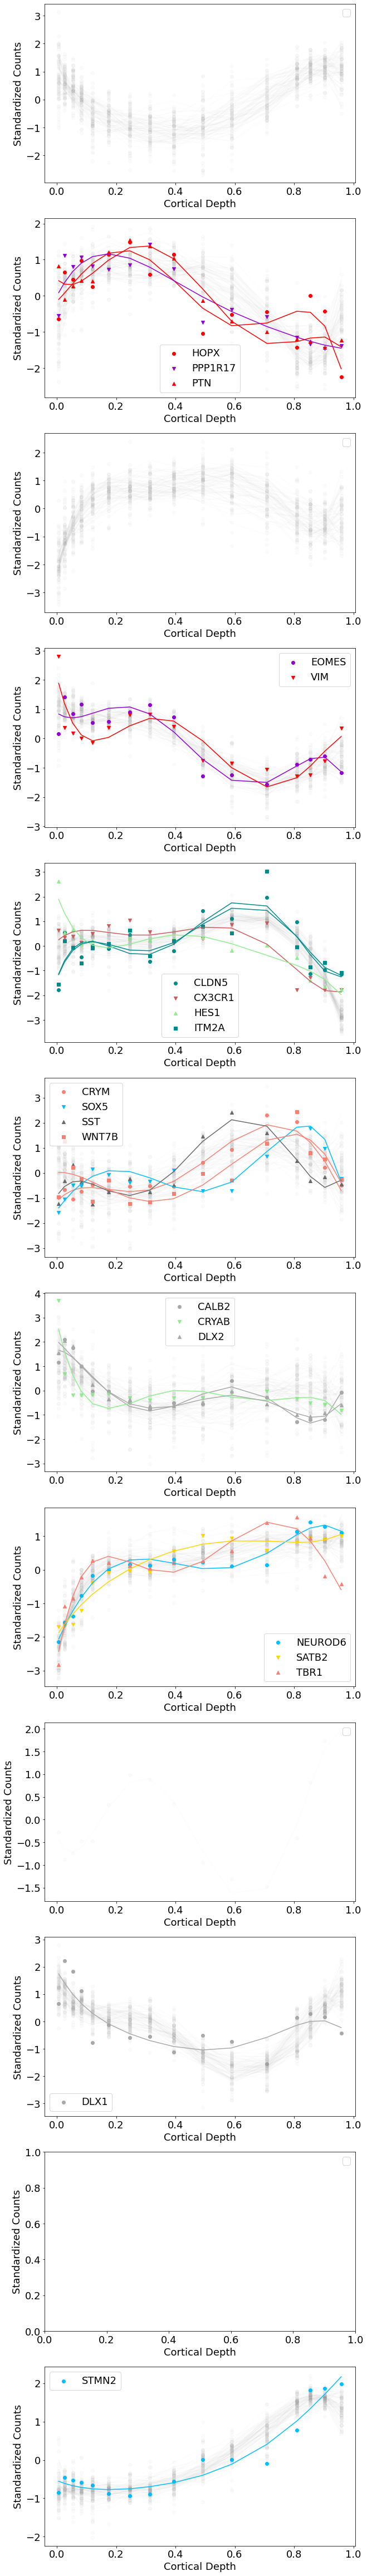

In [44]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c_palette = ('blue', 'red', 'green', 'yellow')

fig, ax = plt.subplots(n_patterns,1,figsize=(10, n_patterns*7))

for i in range(n_patterns):

    for j in range(np.min([n_topGenes,len(pat_genes[i]['g'])])):
        ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]],
                c = 'grey', alpha = 0.033)
        x = adata.obs['VCDepth'][subset_19pcw]
        y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]]
        ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                   c = 'grey', alpha = 0.02)

    marker_styles = ("o", "v", "^", "s")
    for k in range(n_markerGenes):
        if len(pat_markers[i]) > k:
            colour = list(colourPalette.loc[pat_markers[i][k],:])[0]
            ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                        adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]],
                       label = pat_markers[i][k],
                          c = colour, marker = marker_styles[k])
            x = adata.obs['VCDepth'][subset_19pcw] 
            y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]]
            ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                       c = colour)

    ax[i].set_xlabel('Cortical Depth')
    ax[i].set_ylabel('Standardized Counts')
    ax[i].legend()
plt.savefig('../KR_NAS/0_publication_figures/Figure2_SpatialDE_' + str(n_patterns) + 'patterns_zscore_parameters' + str(m)
                + '_' + str(n) + '.pdf')

70


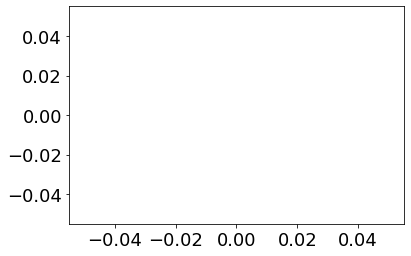

In [73]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c_palette = ('blue', 'red', 'green', 'yellow')

i = 8
print(np.min([n_topGenes,len(pat_genes[i]['g'])]))
for j in range(5,100):
    plt.scatter(adata.obs['VCDepth'][subset_19pcw],
            adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]],
            c = 'grey', alpha = 0.33)
plt.show()

In [85]:
np.unique(adata.X[subset_19pcw,:][:,[np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0] for j in range(100)]].flatten())

array([1.0000e+00, 2.0000e+00, 3.0000e+00, 3.0500e+02, 4.1600e+02,
       4.3900e+02, 5.6100e+02, 7.3900e+02, 9.5000e+02, 1.0580e+03,
       1.1580e+03, 1.2610e+03, 2.2920e+03, 2.3200e+03, 3.4520e+03,
       3.5620e+03, 4.8770e+03, 1.0536e+04, 1.1023e+04], dtype=float32)

Get number of genes in each pattern:

In [40]:
pattern_genes_num = [sum(results_patterns[0]['pattern'] == p) for p in range(n_patterns)]
pattern_genes_num

[495, 1213, 536, 883, 8972, 644, 217, 1075, 408, 654, 0, 1064]

Run through all parameter settings:

In [35]:
dataArray = (input_data, input_data_corrected)
lArray = (0.01,0.02,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.25,1.5,2)

m = 1

for n in range(len(lArray)):
    for n_patterns in np.array((5,8,10,12,15)):
        print(m)
        print(n)
        print(n_patterns)

        results_patterns = SpatialDE.aeh.spatial_patterns(input_coordinates, dataArray[m],
                                                          results_corrected.loc[results_corrected['qval'] < 0.5,:],
                                                          C=n_patterns, l=lArray[n], verbosity=1, maxiter= 1000)

        pat_genes = list()
        for i in range(n_patterns):
            pat1_subset = np.array(results_patterns[0]['pattern'] == i)
            pat_genes.append(results_patterns[0].iloc[pat1_subset].iloc[np.argsort(-results_patterns[0]['membership'].iloc[pat1_subset])])

        colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
        colourCode

        l = list(colourCode.loc[:,'Markers'])
        marker_genes = np.unique([item for sublist in l for item in sublist])

        colourPalette = pd.DataFrame(index = marker_genes, columns = ['Colour'])
        for i in range(len(marker_genes)):
            for j in range(np.shape(colourCode)[0]-1,-1,-1):
                if marker_genes[i] in colourCode.loc[:,'Markers'].iloc[j]:
                    colourPalette.iloc[i,0] = colourCode.iloc[j,2]
        colourPalette

        pat_markers = list()
        for j in range(n_patterns):
            pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
        n_topGenes = 100
        n_markerGenes = 4
        polynomial_order = 5

        marker_genes = marker_genes[marker_genes != 'SOX2']

        pat_markers = list()
        for j in range(n_patterns):
            pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
        n_topGenes = 70
        n_markerGenes = 4
        polynomial_order = 5

        SMALL_SIZE = 18
        MEDIUM_SIZE = 18
        BIGGER_SIZE = 18

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

        c_palette = ('blue', 'red', 'green', 'yellow')

        fig, ax = plt.subplots(n_patterns,1,figsize=(10, n_patterns*7))

        for i in range(n_patterns):

            for j in range(np.min([n_topGenes,len(pat_genes[i]['g'])])):
                ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                        adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]],
                        c = 'grey', alpha = 0.033)
                x = adata.obs['VCDepth'][subset_19pcw]
                y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]]
                ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                           c = 'grey', alpha = 0.02)

            marker_styles = ("o", "v", "^", "s")
            for k in range(n_markerGenes):
                if len(pat_markers[i]) > k:
                    colour = list(colourPalette.loc[pat_markers[i][k],:])[0]
                    ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                                adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]],
                               label = pat_markers[i][k],
                                  c = colour, marker = marker_styles[k])
                    x = adata.obs['VCDepth'][subset_19pcw] 
                    y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]]
                    ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                               c = colour)

            ax[i].set_xlabel('Cortical Depth')
            ax[i].set_ylabel('Standardized Counts')
            ax[i].legend()
        plt.savefig('../KR_NAS/0_publication_figures/Figure2_SpatialDE_' + str(n_patterns) + 'patterns_zscore_parameters' + str(m)
                        + '_' + str(n) + '.pdf')

1
0
5
iter 0, ELBO: -3.46e+02
iter 1, ELBO: -4.71e+05, delta_ELBO: 4.70e+05
iter 2, ELBO: -5.11e+05, delta_ELBO: 3.99e+04
iter 3, ELBO: -5.62e+05, delta_ELBO: 5.08e+04
iter 4, ELBO: -5.78e+05, delta_ELBO: 1.67e+04
iter 5, ELBO: -5.84e+05, delta_ELBO: 6.15e+03
iter 6, ELBO: -5.88e+05, delta_ELBO: 3.62e+03
iter 7, ELBO: -5.90e+05, delta_ELBO: 2.05e+03
iter 8, ELBO: -5.91e+05, delta_ELBO: 1.21e+03
iter 9, ELBO: -5.92e+05, delta_ELBO: 1.14e+03
iter 10, ELBO: -5.94e+05, delta_ELBO: 1.47e+03
iter 11, ELBO: -5.95e+05, delta_ELBO: 1.15e+03
iter 12, ELBO: -5.96e+05, delta_ELBO: 6.68e+02
iter 13, ELBO: -5.96e+05, delta_ELBO: 4.37e+02
iter 14, ELBO: -5.97e+05, delta_ELBO: 3.52e+02
iter 15, ELBO: -5.97e+05, delta_ELBO: 3.12e+02
iter 16, ELBO: -5.97e+05, delta_ELBO: 2.80e+02
iter 17, ELBO: -5.97e+05, delta_ELBO: 2.47e+02
iter 18, ELBO: -5.98e+05, delta_ELBO: 2.17e+02
iter 19, ELBO: -5.98e+05, delta_ELBO: 1.90e+02
iter 20, ELBO: -5.98e+05, delta_ELBO: 1.66e+02
iter 21, ELBO: -5.98e+05, delta_ELBO: 1

KeyboardInterrupt: 

In [80]:
pattern_genes_num = [sum(results_patterns[0]['pattern'] == p) for p in range(15)]
pattern_genes_num

[53, 0, 0, 0, 771, 0, 569, 61, 8621, 629, 34, 1005, 627, 0, 431]

In [22]:
results_patterns[0].to_csv('../KR_NAS/0_publication_tables/SpatialDE_clusters.csv')

In [23]:
colourPalette

,Colour
5,darkgreen
AIF1,indianred
BCL11B,blue
CALB2,darkgray
CLDN5,darkcyan
CRYAB,lightgreen
CRYM,salmon
CX3CR1,indianred
DLX1,darkgray
DLX2,darkgray


In [24]:
pat_genes

[             g  pattern  membership
 4209        C6        0    0.999986
 16156   SDHAF3        0    0.999984
 12357  C6orf58        0    0.999984
 8285     OR1E3        0    0.999981
 9550      RTP1        0    0.999981
 ...        ...      ...         ...
 843     ELOVL7        0    0.467538
 9457     RNF25        0    0.453167
 5260      DIO2        0    0.437298
 2491     CENPJ        0    0.432845
 1103   RAB3IL1        0    0.376124
 
 [7416 rows x 3 columns],
                          g  pattern  membership
 16725                TANC2        1    0.999778
 13542                  FRY        1    0.999696
 13575  GABARAPL3,GABARAPL1        1    0.999659
 17014               TNRC6C        1    0.999630
 13036                 DGKI        1    0.999623
 ...                    ...      ...         ...
 17702              CAMSAP1        1    0.438436
 14104              KATNBL1        1    0.432283
 2887                 NR4A2        1    0.413534
 8786                  PLEC        1  

Can we also find subplate markers that are not in polioudakis 2019?

In [11]:
polioudakis_markers = ('LMO3', 'FBXW7', 'GRIA2', 'TLE4', 'MEG3', 'VCAN', 'LMO7', 'NR4A2', 'NRCAM', 'MEF2C', 'CHL1', 'ST18',
                      'ANK3', 'SYT1', 'CALM1', 'NFIA', 'NRXN1', 'TMEM178A', 'CHGB', 'NEGR1', 'SMARCA2', 'GRIN2B',
                      'MYT1L', 'WASF1', 'C14orf37', 'NREP', 'KAT6B', 'ATP1B1', 'PKIA', 'COMMD2', 'SCD5',
                      'DAAM1', 'EPHA7', 'RTN1', 'CACNG8', 'KIAA1456', 'SORCS1', 'RAP2A', 'SH3GL2',
                      'CADM1', 'MARK1', 'TP53l11', 'ZNF385D', 'KIDINS220', 'PRKACB', 'CHML', 'PLEKHA5', 'ZFHX3', 'SCN2A',
                      'ITSN1', 'NUAK1', 'SESN3', 'CDKL2', 'PPP1R1B', 'CTNND2', 'KCTD12', 'KIFAP3',
                      'SERINC1', 'VSNL1', 'DST', 'MDH1', 'SCG5', 'SGIP1', 'DPP10', 'FXYD6', 'MGLL',
                      'KIF1B', 'MAPT', 'CELF4', 'GPR22', 'TBR1', 'PGM2L1', 'SLC4A10', 'EIF4A2',
                      'FAM171B')

In [12]:
[p for p in polioudakis_markers if p not in adata.var_names]

['MEG3', 'C14orf37', 'KIAA1456', 'TP53l11', 'SCG5']

In [13]:
modules = pd.read_csv('/nfs/team283/aa16/KR_NAS/0_publication_tables/SupplementaryTableX_SpatialDE-Modules.csv')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


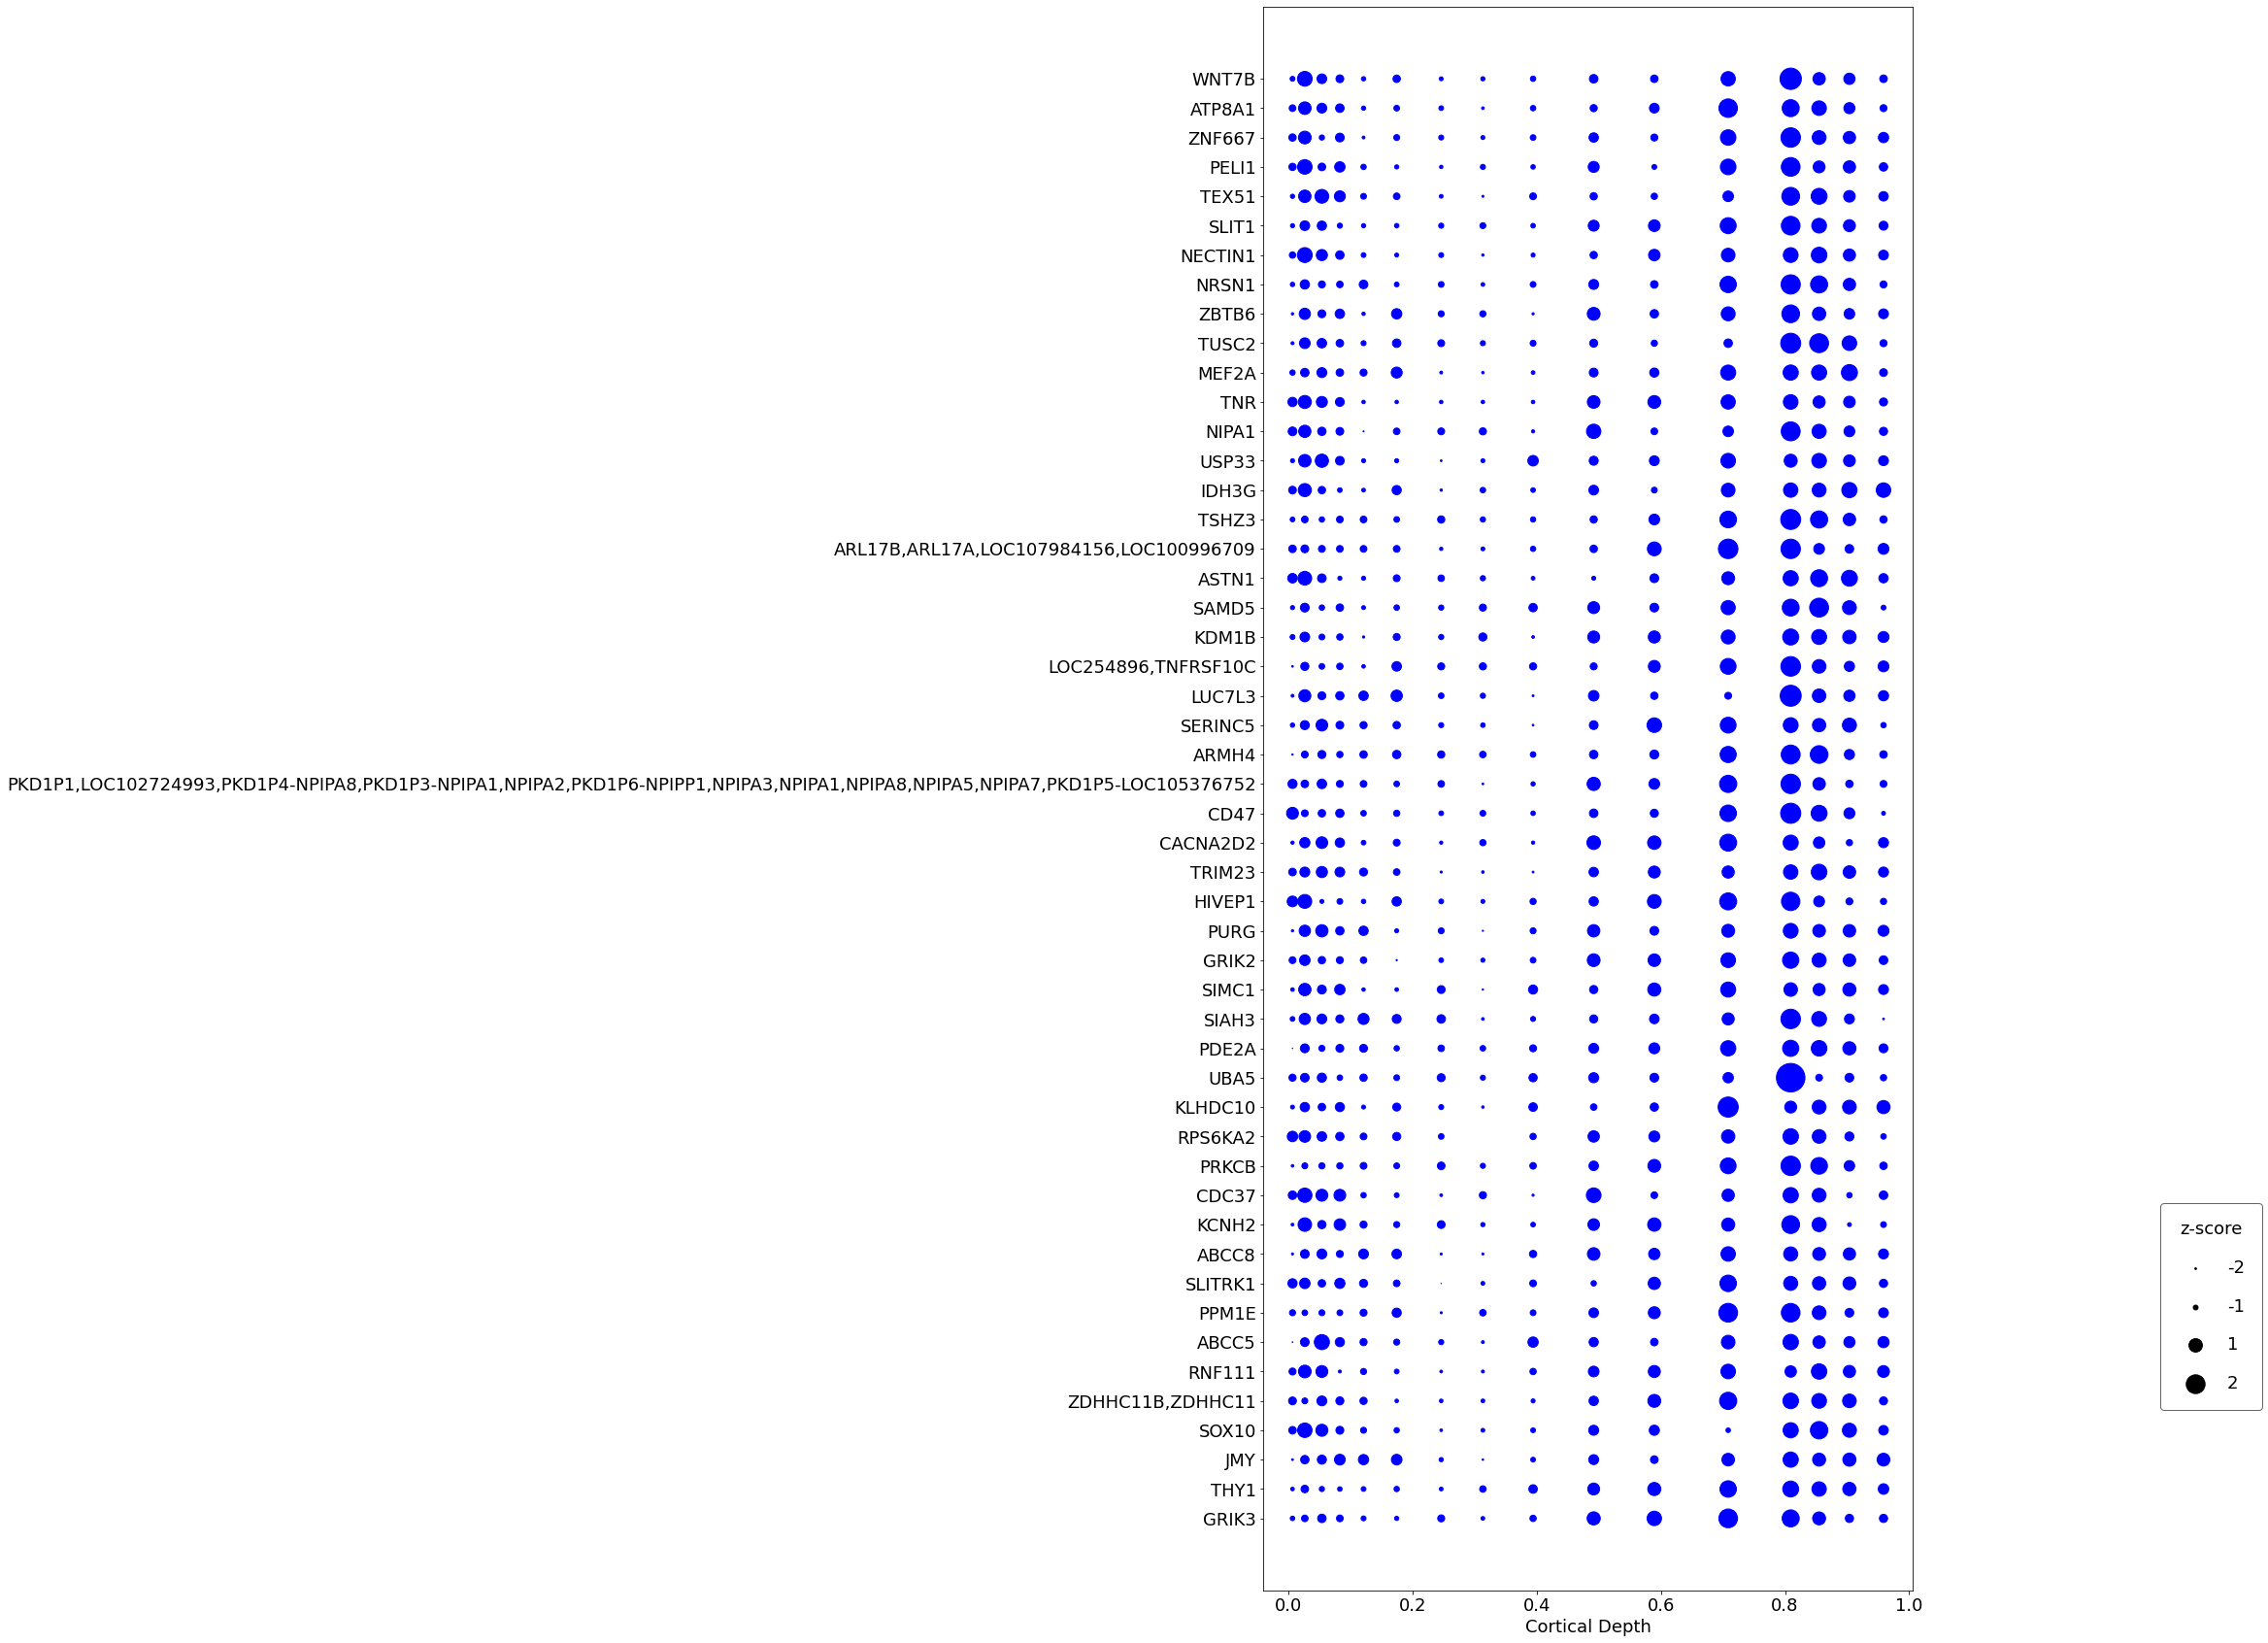

In [14]:
mod5_genes = np.array(modules['g'].loc[modules['pattern'] == 5])
mod5_genes = np.array([m for m in mod5_genes if m not in polioudakis_markers])
mod5_genes = mod5_genes[np.argsort(-np.array([np.corrcoef(adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == mod5_genes[i])[0][0]],
            adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == 'WNT7B')[0][0]])[0,1]
 for i in range(len(mod5_genes))]))]

scaling = 3
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(mod5_genes[0:50])

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

plt.figure(figsize = (12,30))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/SupplementaryFigure_SubplateMarkers_WNT7B.pdf', bbox_extra_artists=(lgd,))

Plot those markers also in the polioudakis 2019 data:

In [34]:
import seaborn as sns
# Get reference scRNAseq data:
meanExpression_sc_1 = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles_subclusters.csv", index_col=0)
meanExpression_sc_2 = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)
meanExpression_sc = pd.concat([meanExpression_sc_2, meanExpression_sc_1.loc[:,'ExDp1_2']], axis = 1)

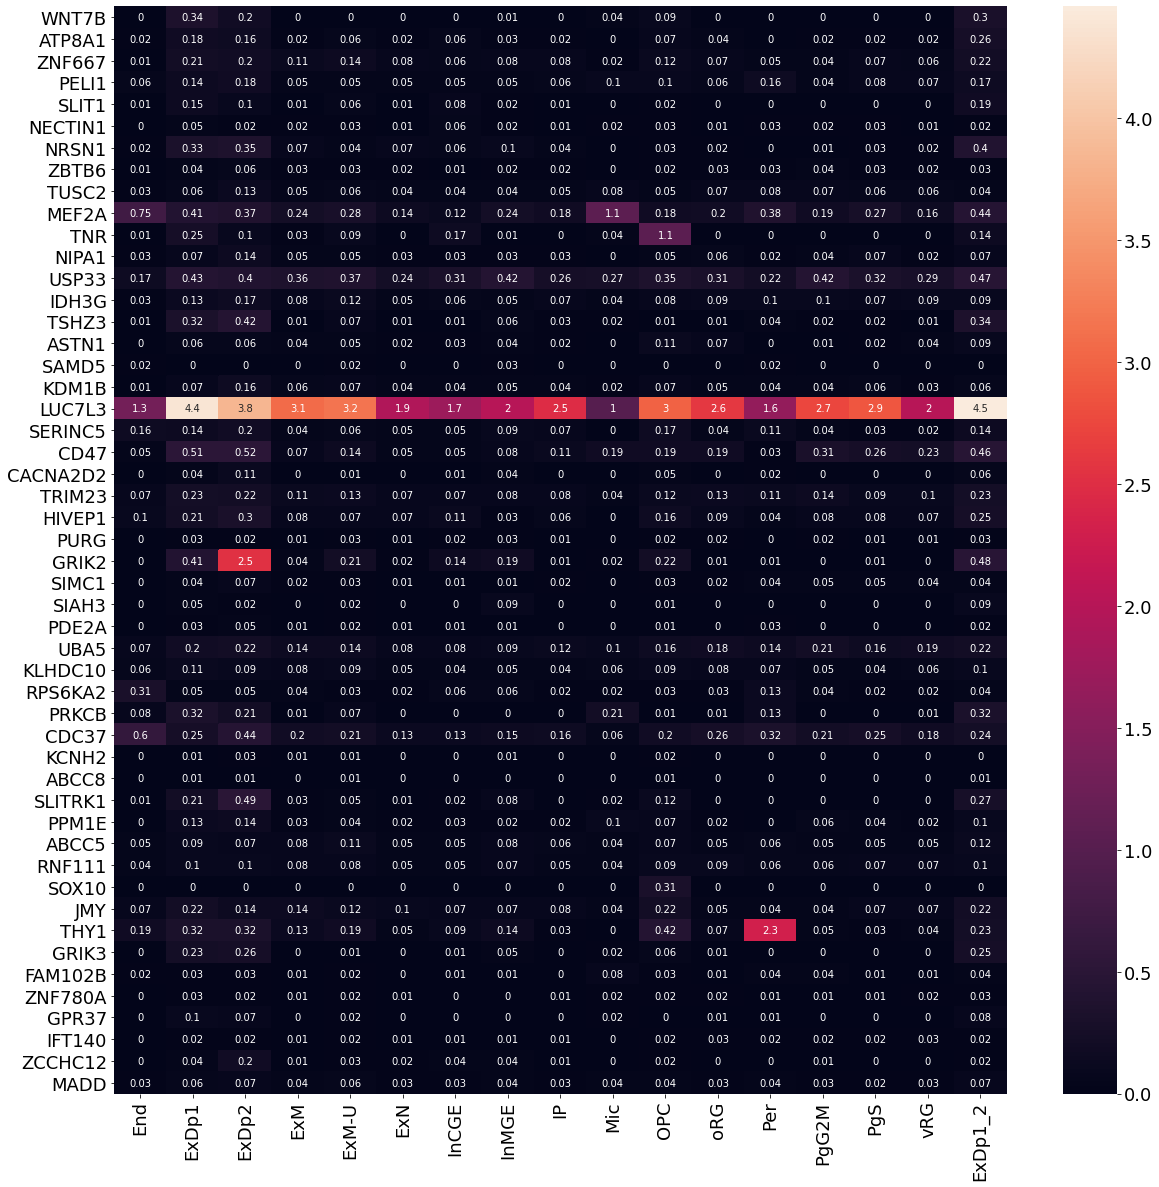

In [37]:
relevant_genes = [m for m in mod5_genes if m in meanExpression_sc.index][0:50]
plt.subplots(figsize=(20,20))
sns.heatmap(np.round(meanExpression_sc.loc[relevant_genes,:],2), annot = True,  annot_kws={"size": 10})
plt.savefig('/nfs/team283/aa16/KR_NAS/0_publication_figures/NewSubplateMarkersWNT7B_InPolioudakis2019.png')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


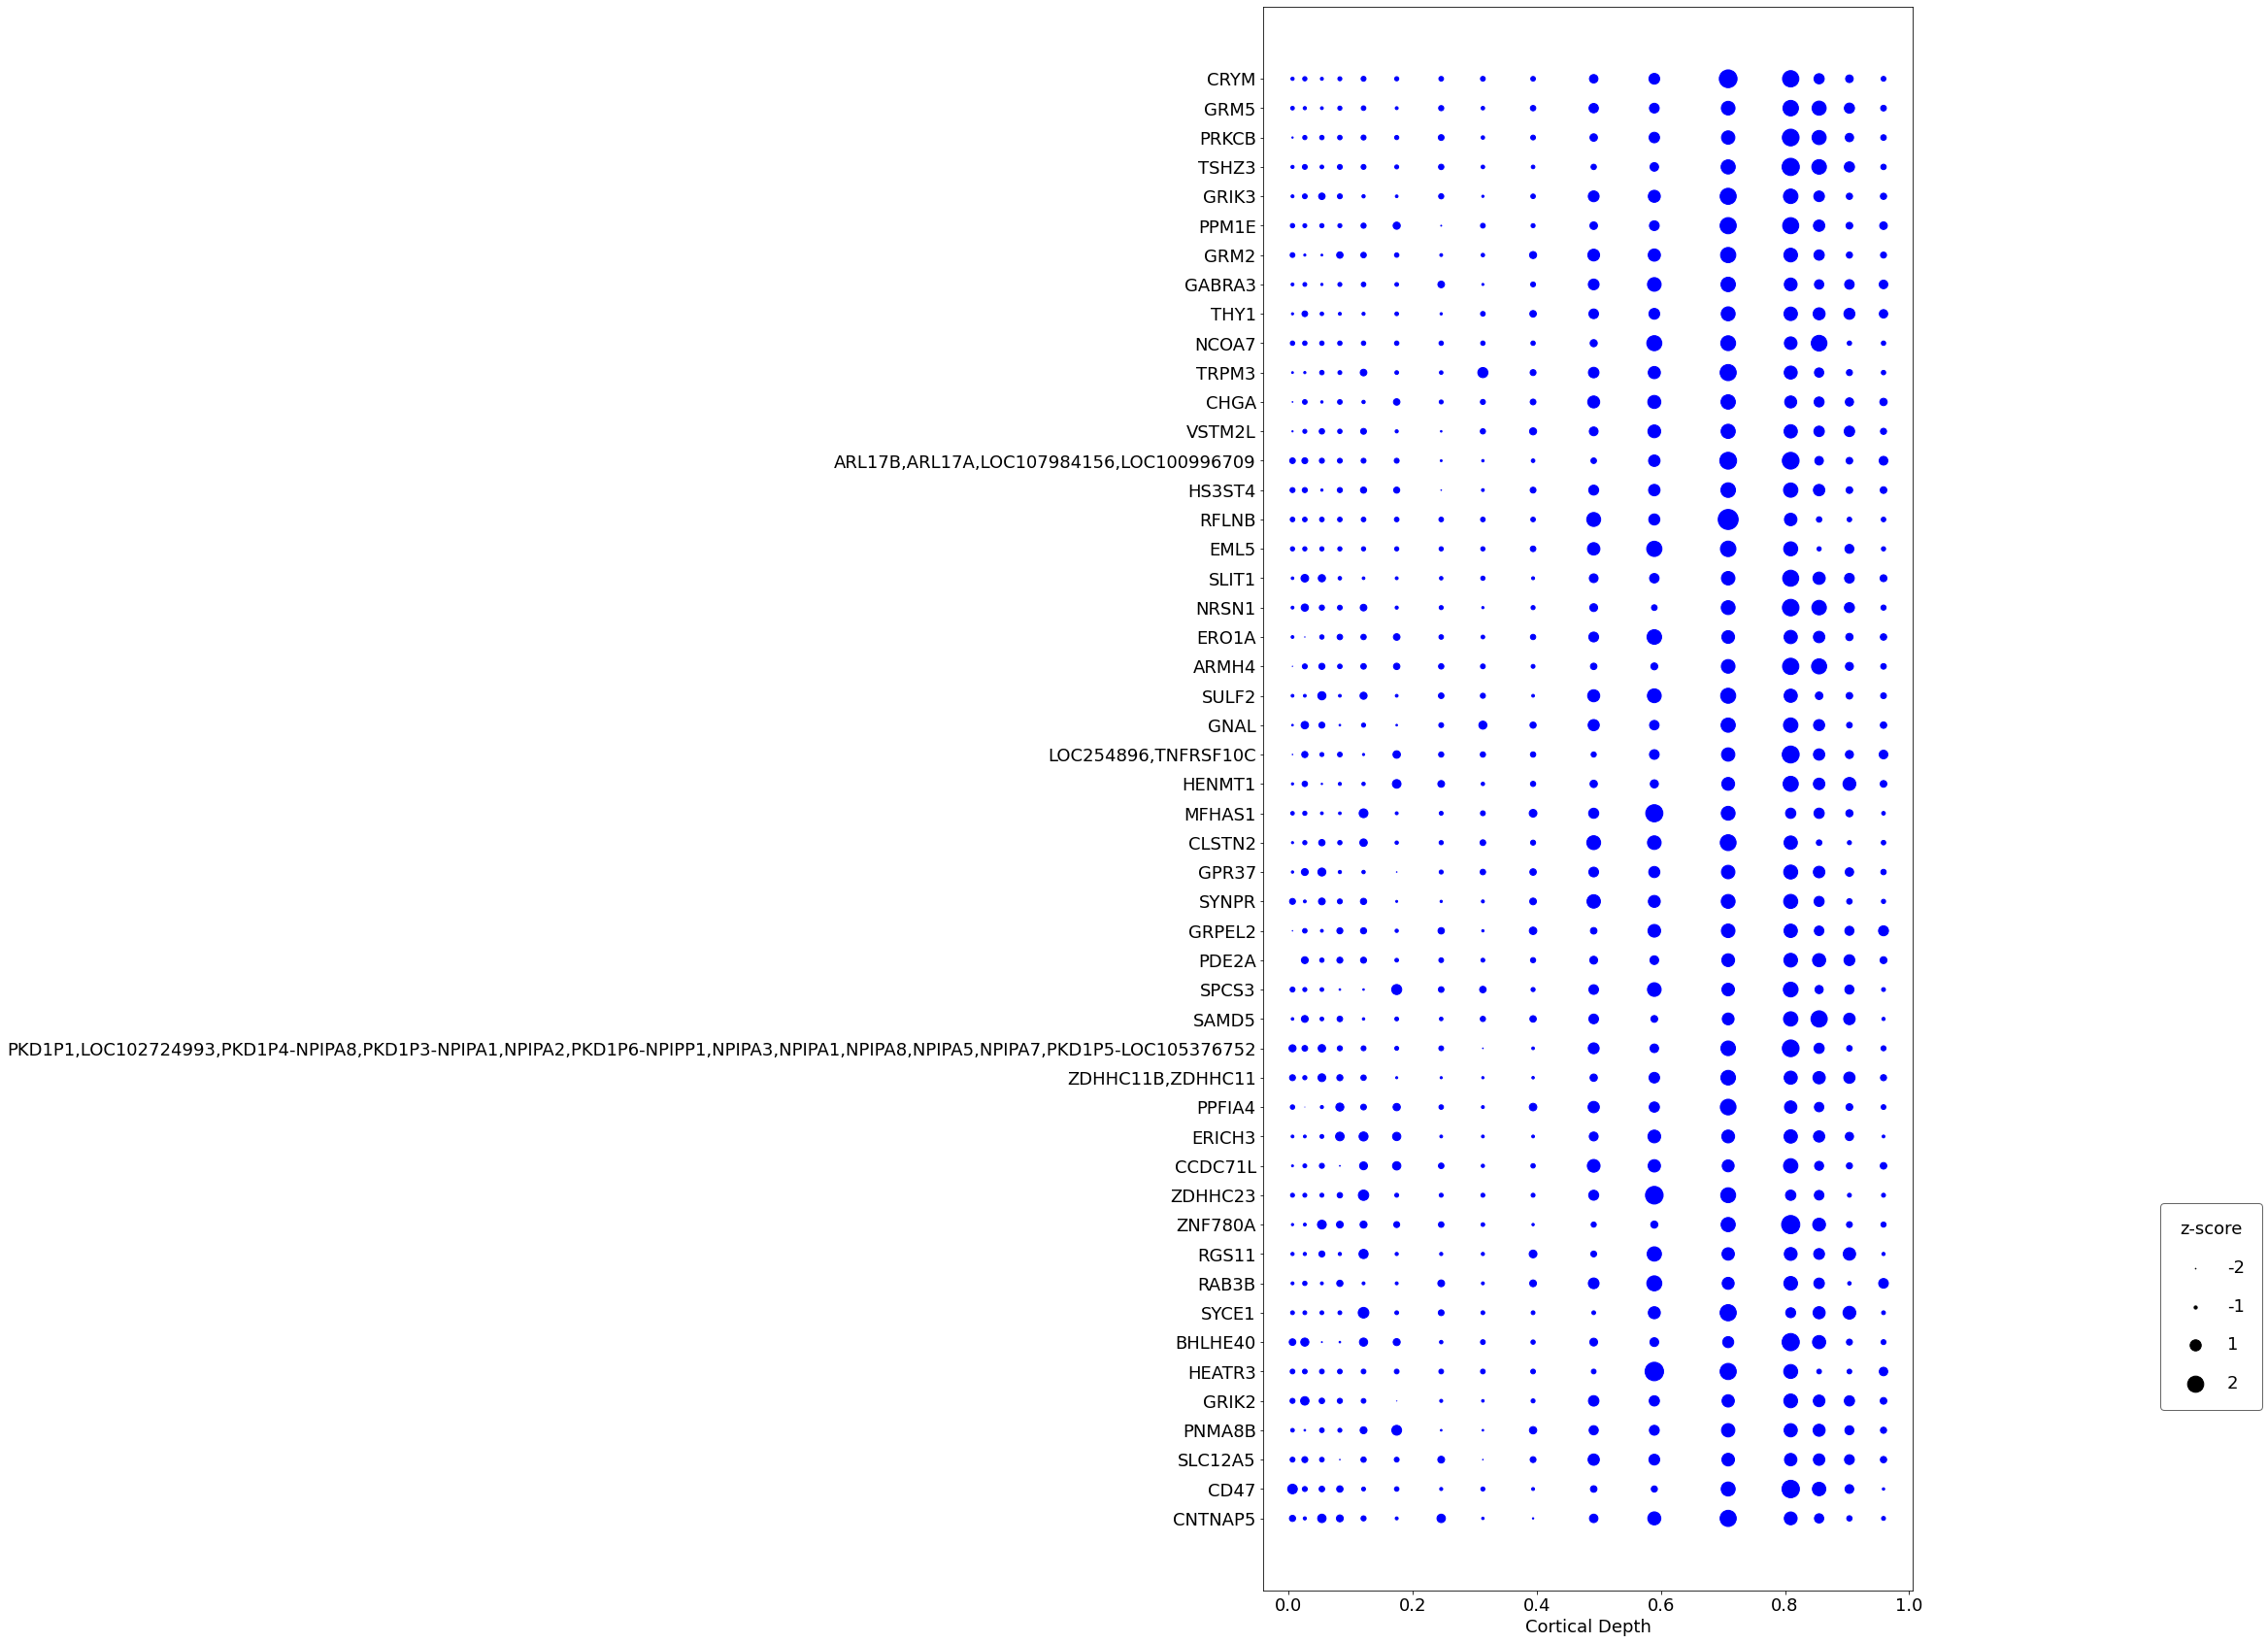

In [38]:
mod5_genes = np.array(modules['g'].loc[modules['pattern'] == 5])
mod5_genes = np.array([m for m in mod5_genes if m not in polioudakis_markers])
mod5_genes = mod5_genes[np.argsort(-np.array([np.corrcoef(adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == mod5_genes[i])[0][0]],
            adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == 'CRYM')[0][0]])[0,1]
 for i in range(len(mod5_genes))]))]

scaling = 3
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(mod5_genes[0:50])

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

plt.figure(figsize = (12,30))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/SupplementaryFigure_SubplateMarkers_CRYM.pdf', bbox_extra_artists=(lgd,))

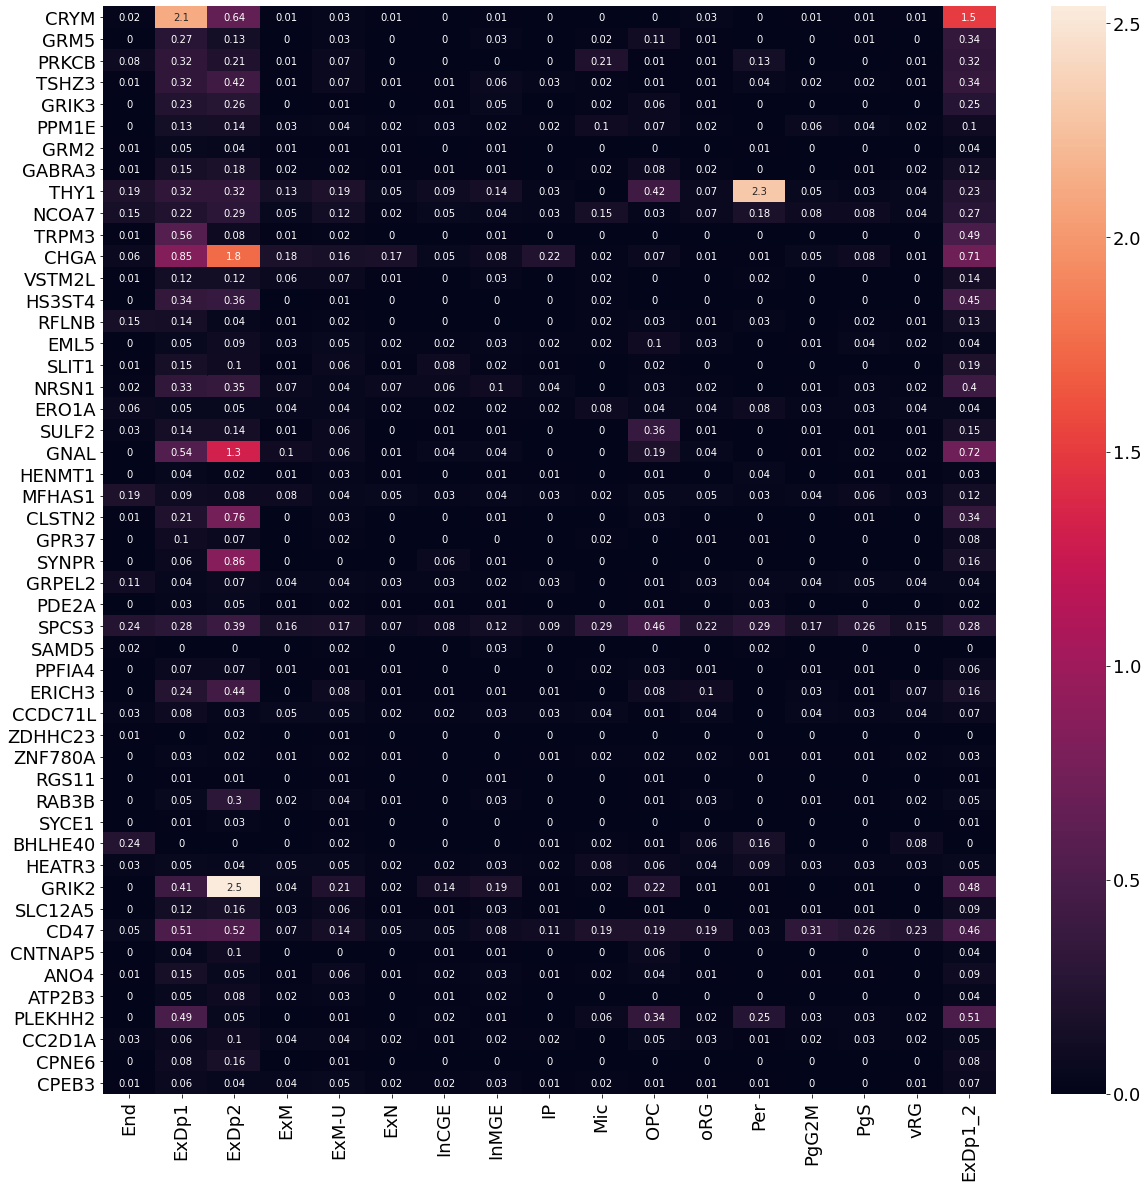

In [39]:
relevant_genes = [m for m in mod5_genes if m in meanExpression_sc.index][0:50]
plt.subplots(figsize=(20,20))
sns.heatmap(np.round(meanExpression_sc.loc[relevant_genes,:],2), annot = True,  annot_kws={"size": 10})
plt.savefig('/nfs/team283/aa16/KR_NAS/0_publication_figures/NewSubplateMarkersCRYM_InPolioudakis2019.png')